# Text2Phoneme Transformer 
In this notebook we build a model that converts sentences to phoneme sequences using a transformer model. The model is trained on the timit_asr dataset and several experiments are run to evaluate it's performance

## Setup
1. connect the notebook to drive to load custom class
2. load necessary pip packages
3. load the timit_asr dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import sys

WORKSPACE_DIR = 'college/595_final_project'
WORKSPACE_PATH = os.path.join('drive', 'My Drive', WORKSPACE_DIR)
sys.path.append(WORKSPACE_PATH)

In [4]:
!pip install datasets
!pip install pytorch-nlp

     |████████████████████████████████| 298 kB 8.0 MB/s 
     |████████████████████████████████| 61 kB 662 kB/s 
     |████████████████████████████████| 243 kB 54.1 MB/s 
     |████████████████████████████████| 132 kB 59.8 MB/s 
     |████████████████████████████████| 1.1 MB 53.5 MB/s 
     |████████████████████████████████| 192 kB 62.9 MB/s 
     |████████████████████████████████| 160 kB 65.2 MB/s 
     |████████████████████████████████| 271 kB 75.4 MB/s 
     |████████████████████████████████| 90 kB 5.5 MB/s 


In [9]:
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import random
from datasets import load_dataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
timit_dataset = load_dataset('timit_asr')

Downloading:   0%|          | 0.00/869M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset timit_asr downloaded and prepared to /root/.cache/huggingface/datasets/timit_asr/clean/2.0.1/5bebea6cd9df0fc2c8c871250de23293a94c1dc49324182b330b6759ae6718f8. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from torchnlp.word_to_vector import GloVe
vocab_to_glove = GloVe(name='6B', dim=300)

## Data Processing Functions
In this section we define the following functions to process the timit_asr dataset:

`map_phonemes_to_words` - defines a mapping between each phoneme in the  phoneme sequence to the word it came from in the original sentence

`preprocess_timit_data` - process the huggingface dataset object and store each datapoint as a triplet of sentence, phoneme sequence, and phoneme word mappings

`vectorize_seq` - converts a sequence of tokens to a pytorch tensor

`vectorize_mappings` - converts a list of phoneme to word mappings to a pytorch tensor 

`vectorize_pair` - returns a vectorized representation of a preprocessed timit_asr datapoint

`build_dataset` - creates a pytorch dataset object from the preprocessed timit_asr data

In [10]:
def map_phonemes_to_words(dp):
  word_idx = 0
  phoneme_idx = 0
  mappings = []
  for word_stop_time in dp['word_detail']['stop']:
    while word_stop_time >= dp['phonetic_detail']['stop'][phoneme_idx]:
      mappings.append(word_idx)
      phoneme_idx += 1
    word_idx += 1

  while phoneme_idx < len(dp['phonetic_detail']['utterance']):
    mappings.append(word_idx-1)
    phoneme_idx += 1

  phonetic_len = len(dp['phonetic_detail']['utterance'])
  assert len(mappings) == len(dp['phonetic_detail']['utterance']), f'ASSERT FAILED: mapping len: {len(mappings)} vs phoneme len: {phonetic_len}'
  return mappings

def preprocess_timit_data(data):
  pairs = []
  for dp in data:
    word_seq = dp['word_detail']['utterance']
    phoneme_seq = dp['phonetic_detail']['utterance']
    phoneme_word_mappings = map_phonemes_to_words(dp)
    pairs.append((word_seq, phoneme_seq, phoneme_word_mappings))
  return pairs

In [19]:
print(timit_dataset['train'][4497]['word_detail']['utterance'])
print(timit_dataset['train'][4497]['phonetic_detail']['utterance'][1:-1])
print(map_phonemes_to_words(timit_dataset['train'][4497])[1:-1])

['such', 'legislation', 'was', 'clarified', 'and', 'extended', 'from', 'time', 'to', 'time', 'thereafter']
['s', 'ah', 'sh', 'l', 'eh', 'dcl', 'jh', 'ax', 's', 'l', 'ey', 'sh', 'en', 'w', 'ax', 'z', 'kcl', 'k', 'l', 'eh', 'axr', 'f', 'ay', 'dcl', 'en', 'ix', 'kcl', 'k', 's', 'tcl', 't', 'eh', 'n', 'd', 'ix', 'dcl', 'f', 'em', 'tcl', 't', 'ay', 'm', 'tcl', 't', 'ax', 'tcl', 't', 'ay', 'm', 'dh', 'eh', 'r', 'ae', 'f', 'tcl', 't', 'axr']
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]


In [ ]:
def vectorize_seq(token_encoder, sequence):
  indexes = [token_encoder.bos_token_id] + [token_encoder.get_token_index(token) for token in sequence] + [token_encoder.eos_token_id]
  if len(indexes) < MAX_LEN:
    indexes = indexes + [token_encoder.pad_token_id] * (MAX_LEN - len(indexes))
  else:
    indexes = indexes[:MAX_LEN]
  return torch.tensor(indexes, dtype=torch.long, device=DEVICE)

def glove_vectorize_seq(token_encoder, sequence):
  embedding_matrix = torch.zeros((MAX_LEN, HID_DIM), dtype=torch.float32, device=DEVICE)
  sum = 0
  for word_idx, word in enumerate(sequence):
    if word_idx == MAX_LEN:
      break
    if token_encoder.get_token_index(word) == token_encoder.unk_token_id:
      embedding_matrix[word_idx] = 1
    word = word.replace("'", "")
    if word not in vocab_to_glove:
      embedding_matrix[word_idx] = 1
    else:
      embedding_matrix[word_idx] = vocab_to_glove[word][:HID_DIM]
  return embedding_matrix


def vectorize_mappings(indexes):
  indexes = [0] + [i + 1 for i in indexes] + [indexes[-1]+1]
  if len(indexes) < MAX_LEN:
    indexes = indexes + [MAX_LEN+1] * (MAX_LEN - len(indexes))
  else:
    indexes = indexes[:MAX_LEN]
  return torch.tensor(indexes, dtype=torch.long, device=DEVICE)


def vectorize_pair(pair, use_glove=False):
  if use_glove:
    word_vector = glove_vectorize_seq(word_encoder, pair[0])
  else:
    word_vector = vectorize_seq(word_encoder, pair[0])

  phoneme_vector = vectorize_seq(phoneme_encoder, pair[1])
  phone_word_mapping_vector = vectorize_mappings(pair[2])
  return word_vector, phoneme_vector, phone_word_mapping_vector

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

def build_dataset(pairs):
  word_vecs = torch.ones((len(pairs), MAX_LEN), dtype=torch.long)
  phoneme_vecs = torch.ones((len(pairs), MAX_LEN), dtype=torch.long)
  phoneme_word_mapping_vecs = torch.ones((len(pairs), MAX_LEN), dtype=torch.long)
  for idx, pair in enumerate(pairs):
    word_vec, phoneme_vec, mapping_vec = vectorize_pair(pair)
    word_vecs[idx] = word_vec
    phoneme_vecs[idx] = phoneme_vec
    phoneme_word_mapping_vecs[idx] = mapping_vec

  return TensorDataset(word_vecs, phoneme_vecs, phoneme_word_mapping_vecs)

def build_glove_dataset(pairs):
  word_vecs = torch.ones((len(pairs), MAX_LEN, HID_DIM), dtype=torch.long)
  phoneme_vecs = torch.ones((len(pairs), MAX_LEN), dtype=torch.long)
  phoneme_word_mapping_vecs = torch.ones((len(pairs), MAX_LEN), dtype=torch.long)
  for idx, pair in enumerate(pairs):
    word_vec, phoneme_vec, mapping_vec = vectorize_pair(pair, use_glove=True)
    word_vecs[idx] = word_vec
    phoneme_vecs[idx] = phoneme_vec
    phoneme_word_mapping_vecs[idx] = mapping_vec

  return TensorDataset(word_vecs, phoneme_vecs, phoneme_word_mapping_vecs)

## Training Functions
Here we defined the functions we need for training the model. The model itself is defined in `transformers.py`

`initialize_weights` - initializes the weights for a seq2seq transformer model

`train` - contains the core training code

`evaluate` - evaluates the model

`get_metrics` - provides model performance metrics on a dataset

`get_samples` - generates samples given a model

In [ ]:
def initialize_weights(m):
  if hasattr(m, 'weight') and m.weight.dim() > 1:
    nn.init.xavier_uniform_(m.weight.data)

def train(model, iterator, optimizer, vocab_criterion, mapping_criterion, clip):
  model.train()
  
  epoch_loss = 0
  
  for i, batch in enumerate(iterator):
      
    src = batch[0].to(DEVICE) 
    trg = batch[1].to(DEVICE) 
    trg_mapping = batch[2].to(DEVICE)
    
    optimizer.zero_grad()
    
    output, output_mapping, _ = model(src, trg[:,:-1])
    output_dim = output.shape[-1]
    output_mapping_dim = output_mapping.shape[-1]
        
    output = output.contiguous().view(-1, output_dim)
    trg = trg[:,1:].contiguous().view(-1)

    output_mapping = output_mapping.contiguous().view(-1, output_mapping_dim)
    trg_mapping = trg_mapping[:,1:].contiguous().view(-1)


    loss = vocab_criterion(output, trg) # + mapping_criterion(output_mapping, trg_mapping) 
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
    
    optimizer.step()
    
    epoch_loss += loss.item()
        
  return epoch_loss / len(iterator)

In [ ]:
from nltk.translate import bleu
from nltk.translate.bleu_score import SmoothingFunction

def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs


def edit_score(pred, truth, padding_token = None):
    # if the lists are padded, then remove the padding before calculating edit distance
    if padding_token:
        if padding_token in pred:
            pred = pred[:pred.index(padding_token)]

        if padding_token in truth:
            truth = truth[:pred.index(padding_token)]

        print(pred, truth)

    m = len(pred)
    n = len(truth)
    # Create a table to store results of subproblems
    dp = [[0 for x in range(n + 1)] for x in range(m + 1)]
  
    # Fill d[][] in bottom up manner
    for i in range(m + 1):
        for j in range(n + 1):
  
            # If first list is empty, only option is to
            # insert all elements of second list
            if i == 0:
                dp[i][j] = j    # Min. operations = j
  
            # If second list is empty, only option is to
            # remove all elements of second list
            elif j == 0:
                dp[i][j] = i    # Min. operations = i
  
            # If last elements are same, ignore last char
            # and recur for remaining list

            elif pred[i - 1] == truth[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
  
            # If last elements are different, consider all
            # possibilities and find minimum
            else:
                dp[i][j] = 1 + min(dp[i][j - 1],        # Insert
                                   dp[i - 1][j],        # Remove
                                   dp[i - 1][j - 1])    # Replace
  
    # normalize the edit distance by dividing the number edit distance by the the length of truth
    return dp[m][n] / n

def accuracy_fn(ref, pred, index=None):
  if index:
    ref = ref[: min(len(ref), index)]
    pred = pred[: min(len(pred), index)]
  if len(ref) > len(pred):
    pred = pred + [-1] * (len(ref) - len(pred))
  if len(pred) > len(ref):
    pred = pred[: len(pred)]    

  return sum(1 for x,y in zip(ref, pred) if x == y) / len(ref)

def evaluate(model, dataloader, vocab_criterion, mapping_criterion):

  smoothie = SmoothingFunction().method4
  
  bleu_score = 0
  phoneme_accuracy = 0
  edit_dist = 0
  vocab_loss = 0
  mapping_loss = 0
  num_datapoints = 0

  mapping_ed = 0
  mapping_acc = 0

  model.eval()
  with torch.no_grad():
    for i, batch in enumerate(dataloader):
      src = batch[0].to(DEVICE) # (seq_len, batch_size)
      trg = batch[1].to(DEVICE) # (seq_len, batch_size)
      trg_mapping = batch[2].to(DEVICE)

      optimizer.zero_grad()
          
      output, output_mapping, _ = model(src, trg[:,:-1]) # (batch size, trg len - 1, output dim)
      output_dim = output.shape[-1]
      output_mapping_dim = output_mapping.shape[-1]

      vocab_loss += vocab_criterion(output.reshape(-1, output_dim), trg[:,1:].reshape(-1))
      mapping_loss += mapping_criterion(output_mapping.reshape(-1, output_mapping_dim), trg_mapping[:,1:].reshape(-1))


      output = output.argmax(-1)
      output_mapping = output_mapping.argmax(-1)

      for j in range(len(batch[0])):
        num_datapoints += 1

        predicted_sequence = phoneme_encoder.decode_sequence(output[j].tolist())
        target_sequence = phoneme_encoder.decode_sequence(trg[j].tolist())[1:]

        predicted_mapping = output_mapping[j].tolist()
        target_mapping = trg_mapping[j].tolist()[1:]

        if phoneme_encoder.eos_token in predicted_sequence:
          predicted_sequence = predicted_sequence[:predicted_sequence.index(phoneme_encoder.eos_token)]
        target_len = len(target_sequence)
        if phoneme_encoder.eos_token in target_sequence:
          target_len = target_sequence.index(phoneme_encoder.eos_token)
          target_sequence = target_sequence[:target_len]

        predicted_mapping = predicted_mapping[:target_len]   
        target_mapping = target_mapping[:target_len]   

        bleu_score += bleu([target_sequence], predicted_sequence, smoothing_function=smoothie)
        phoneme_accuracy += accuracy_fn(target_sequence, predicted_sequence)
        edit_dist += edit_score(target_sequence, predicted_sequence)

        mapping_acc += accuracy_fn(target_mapping, predicted_mapping)
        mapping_ed += edit_score(target_mapping, predicted_mapping)        

  return {
      'phoneme_acc': phoneme_accuracy/num_datapoints, 
      'phoneme_bleu': bleu_score/num_datapoints,
      'phoneme_edit': edit_dist/num_datapoints,
      'mapping_acc': mapping_acc/num_datapoints,
      'mapping_ed': mapping_ed/num_datapoints,
      'vocab_loss': vocab_loss.cpu().numpy() / len(dataloader)
  }

def generate_samples(model, dataloader):
  smoothie = SmoothingFunction().method4
  samples = []

  with torch.no_grad():
    for i, batch in enumerate(dataloader):
      src = batch[0].to(DEVICE) # (seq_len, batch_size)
      trg = batch[1].to(DEVICE) # (seq_len, batch_size)
      trg_mapping = batch[2].to(DEVICE)


      optimizer.zero_grad()
          
      output, output_mapping, _ = model(src, trg[:,:-1]) # (batch size, trg len - 1, output dim)
      output = output.argmax(-1)
      output_mapping = output_mapping.argmax(-1)

                
      for j in range(len(batch[0])):

        predicted_sequence = phoneme_encoder.decode_sequence(output[j].tolist())
        target_sequence = phoneme_encoder.decode_sequence(trg[j].tolist())[1:]


        predicted_mapping = output_mapping[j].tolist()
        target_mapping = trg_mapping[j].tolist()[1:]

        if phoneme_encoder.eos_token in predicted_sequence:
          predicted_sequence = predicted_sequence[:predicted_sequence.index(phoneme_encoder.eos_token)]

        target_len = len(target_sequence)
        if phoneme_encoder.eos_token in target_sequence:
          target_len = target_sequence.index(phoneme_encoder.eos_token)
          target_sequence = target_sequence[:target_len]

        predicted_mapping = predicted_mapping[:target_len]   
        target_mapping = target_mapping[:target_len]            

        phoneme_accuracy = accuracy_fn(target_sequence, predicted_sequence)
        bleu_score = bleu([target_sequence], predicted_sequence, smoothing_function=smoothie)
        edit_dist = edit_score(target_sequence, predicted_sequence)

        mapping_acc = accuracy_fn(target_mapping, predicted_mapping)
        mapping_ed = edit_score(target_mapping, predicted_mapping)             

        samples.append({
            'target': target_sequence,
            'predicted': predicted_sequence,
            'target_mapping': target_mapping,
            'predicted_mapping': predicted_mapping,
            'phoneme_accuracy': phoneme_accuracy,
            'phoneme_bleu': bleu_score,
            'phoneme_edit': edit_dist,
            'mapping_ed': mapping_ed,
            'mapping_acc': mapping_acc,
        })

  return samples

## Training Paramaters

In [ ]:
# GLOBALS
MAX_LEN = 72

# MODEL HYPERPARAMS
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512

# TRAINING PARAMS
BATCH_SIZE = 128
N_EPOCHS = 50
LEARNING_RATE = 0.0005


# REGULARIZATION PARAMATERS
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1
CLIP = 1

## Data Processing

In this section we use the helper functions defined above to process the timit_asr dataset into a pytorch dataloader that we can feed into the seq2seq transformer model

In [ ]:
from token_encoder import TokenEncoder, build_io_token_encodings

train_pairs = preprocess_timit_data(timit_dataset['train'])
test_pairs = preprocess_timit_data(timit_dataset['test'])


word_encoder = TokenEncoder(MAX_LEN)
phoneme_encoder = TokenEncoder(MAX_LEN)
build_io_token_encodings(word_encoder, phoneme_encoder, train_pairs)
print(f'training points: {len(train_pairs)}, num input tokens: {word_encoder.n_tokens}, num output tokens: {phoneme_encoder.n_tokens}')

# train_dataset = build_dataset(train_pairs)
train_dataset = build_glove_dataset(train_pairs)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

# eval_dataset = build_dataset(test_pairs)
eval_dataset = build_glove_dataset(test_pairs)
eval_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE) 

training points: 4620, num input tokens: 4897, num output tokens: 65


## Model Training
Load and train a seq2seq transformer model

In [ ]:
from transformer import Encoder, Decoder, Seq2Seq


enc = Encoder(word_encoder.n_tokens, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              DEVICE)

dec = Decoder(phoneme_encoder.n_tokens, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              DEVICE)
model = Seq2Seq(enc, dec, word_encoder.pad_token_id, phoneme_encoder.pad_token_id, DEVICE).to(DEVICE)
model.apply(initialize_weights);


optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
vocab_criterion = nn.CrossEntropyLoss(ignore_index = phoneme_encoder.pad_token_id)
mapping_criterion = nn.CrossEntropyLoss(ignore_index = MAX_LEN + 1)


In [ ]:
best_valid_loss = float('inf')

train_losses = []
test_losses = []

test_phoneme_accs = []

epochs = []

for epoch in tqdm(range(N_EPOCHS)):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, vocab_criterion, mapping_criterion, CLIP)
    metrics = evaluate(model, eval_loader, vocab_criterion, mapping_criterion)
    valid_loss = metrics['vocab_loss']
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

    # keep track of numbers we want to plot
    train_losses.append(train_loss)
    test_losses.append(valid_loss)
    test_phoneme_accs.append(metrics['phoneme_acc'])
    epochs.append(epoch)

    
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

  2%|▏         | 1/50 [00:09<07:42,  9.44s/it]

Epoch: 01 | Time: 0m 9s
	Train Loss: 3.477 | Train PPL:  32.377
	 Val. Loss: 2.674 |  Val. PPL:  14.497


  4%|▍         | 2/50 [00:18<07:31,  9.41s/it]

Epoch: 02 | Time: 0m 9s
	Train Loss: 2.550 | Train PPL:  12.804
	 Val. Loss: 2.432 |  Val. PPL:  11.384


  6%|▌         | 3/50 [00:28<07:21,  9.39s/it]

Epoch: 03 | Time: 0m 9s
	Train Loss: 2.373 | Train PPL:  10.735
	 Val. Loss: 2.361 |  Val. PPL:  10.607


  8%|▊         | 4/50 [00:37<07:12,  9.39s/it]

Epoch: 04 | Time: 0m 9s
	Train Loss: 2.300 | Train PPL:   9.973
	 Val. Loss: 2.331 |  Val. PPL:  10.289


 10%|█         | 5/50 [00:47<07:03,  9.40s/it]

Epoch: 05 | Time: 0m 9s
	Train Loss: 2.253 | Train PPL:   9.515
	 Val. Loss: 2.322 |  Val. PPL:  10.195


 12%|█▏        | 6/50 [00:56<06:53,  9.40s/it]

Epoch: 06 | Time: 0m 9s
	Train Loss: 2.213 | Train PPL:   9.141
	 Val. Loss: 2.310 |  Val. PPL:  10.074


 14%|█▍        | 7/50 [01:05<06:45,  9.42s/it]

Epoch: 07 | Time: 0m 9s
	Train Loss: 2.175 | Train PPL:   8.806
	 Val. Loss: 2.331 |  Val. PPL:  10.289


 16%|█▌        | 8/50 [01:15<06:36,  9.44s/it]

Epoch: 08 | Time: 0m 9s
	Train Loss: 2.134 | Train PPL:   8.450
	 Val. Loss: 2.350 |  Val. PPL:  10.481


 18%|█▊        | 9/50 [01:24<06:26,  9.44s/it]

Epoch: 09 | Time: 0m 9s
	Train Loss: 2.089 | Train PPL:   8.078
	 Val. Loss: 2.365 |  Val. PPL:  10.645


 20%|██        | 10/50 [01:34<06:17,  9.44s/it]

Epoch: 10 | Time: 0m 9s
	Train Loss: 2.047 | Train PPL:   7.742
	 Val. Loss: 2.358 |  Val. PPL:  10.566


 22%|██▏       | 11/50 [01:43<06:08,  9.44s/it]

Epoch: 11 | Time: 0m 9s
	Train Loss: 1.999 | Train PPL:   7.382
	 Val. Loss: 2.405 |  Val. PPL:  11.081


 24%|██▍       | 12/50 [01:53<05:58,  9.43s/it]

Epoch: 12 | Time: 0m 9s
	Train Loss: 1.953 | Train PPL:   7.049
	 Val. Loss: 2.374 |  Val. PPL:  10.735


 26%|██▌       | 13/50 [02:02<05:48,  9.41s/it]

Epoch: 13 | Time: 0m 9s
	Train Loss: 1.904 | Train PPL:   6.710
	 Val. Loss: 2.424 |  Val. PPL:  11.289


 28%|██▊       | 14/50 [02:11<05:38,  9.39s/it]

Epoch: 14 | Time: 0m 9s
	Train Loss: 1.860 | Train PPL:   6.426
	 Val. Loss: 2.412 |  Val. PPL:  11.151


 30%|███       | 15/50 [02:21<05:28,  9.38s/it]

Epoch: 15 | Time: 0m 9s
	Train Loss: 1.819 | Train PPL:   6.164
	 Val. Loss: 2.418 |  Val. PPL:  11.221


 32%|███▏      | 16/50 [02:30<05:18,  9.38s/it]

Epoch: 16 | Time: 0m 9s
	Train Loss: 1.773 | Train PPL:   5.886
	 Val. Loss: 2.415 |  Val. PPL:  11.184


 34%|███▍      | 17/50 [02:39<05:09,  9.38s/it]

Epoch: 17 | Time: 0m 9s
	Train Loss: 1.726 | Train PPL:   5.619
	 Val. Loss: 2.448 |  Val. PPL:  11.562


 36%|███▌      | 18/50 [02:49<05:00,  9.40s/it]

Epoch: 18 | Time: 0m 9s
	Train Loss: 1.690 | Train PPL:   5.417
	 Val. Loss: 2.476 |  Val. PPL:  11.895


 38%|███▊      | 19/50 [02:58<04:51,  9.40s/it]

Epoch: 19 | Time: 0m 9s
	Train Loss: 1.648 | Train PPL:   5.196
	 Val. Loss: 2.489 |  Val. PPL:  12.050


 40%|████      | 20/50 [03:08<04:41,  9.39s/it]

Epoch: 20 | Time: 0m 9s
	Train Loss: 1.609 | Train PPL:   4.998
	 Val. Loss: 2.516 |  Val. PPL:  12.378


 42%|████▏     | 21/50 [03:17<04:32,  9.39s/it]

Epoch: 21 | Time: 0m 9s
	Train Loss: 1.577 | Train PPL:   4.838
	 Val. Loss: 2.448 |  Val. PPL:  11.568


 44%|████▍     | 22/50 [03:26<04:22,  9.38s/it]

Epoch: 22 | Time: 0m 9s
	Train Loss: 1.541 | Train PPL:   4.671
	 Val. Loss: 2.543 |  Val. PPL:  12.719


 46%|████▌     | 23/50 [03:36<04:13,  9.37s/it]

Epoch: 23 | Time: 0m 9s
	Train Loss: 1.511 | Train PPL:   4.534
	 Val. Loss: 2.503 |  Val. PPL:  12.224


 48%|████▊     | 24/50 [03:45<04:03,  9.36s/it]

Epoch: 24 | Time: 0m 9s
	Train Loss: 1.482 | Train PPL:   4.403
	 Val. Loss: 2.553 |  Val. PPL:  12.841


 50%|█████     | 25/50 [03:54<03:54,  9.37s/it]

Epoch: 25 | Time: 0m 9s
	Train Loss: 1.454 | Train PPL:   4.282
	 Val. Loss: 2.557 |  Val. PPL:  12.898


 52%|█████▏    | 26/50 [04:04<03:45,  9.40s/it]

Epoch: 26 | Time: 0m 9s
	Train Loss: 1.426 | Train PPL:   4.161
	 Val. Loss: 2.536 |  Val. PPL:  12.628


 54%|█████▍    | 27/50 [04:13<03:36,  9.40s/it]

Epoch: 27 | Time: 0m 9s
	Train Loss: 1.403 | Train PPL:   4.069
	 Val. Loss: 2.529 |  Val. PPL:  12.536


 56%|█████▌    | 28/50 [04:23<03:26,  9.39s/it]

Epoch: 28 | Time: 0m 9s
	Train Loss: 1.387 | Train PPL:   4.001
	 Val. Loss: 2.510 |  Val. PPL:  12.310


 58%|█████▊    | 29/50 [04:32<03:16,  9.38s/it]

Epoch: 29 | Time: 0m 9s
	Train Loss: 1.357 | Train PPL:   3.885
	 Val. Loss: 2.583 |  Val. PPL:  13.230


 60%|██████    | 30/50 [04:41<03:07,  9.37s/it]

Epoch: 30 | Time: 0m 9s
	Train Loss: 1.335 | Train PPL:   3.799
	 Val. Loss: 2.672 |  Val. PPL:  14.467


 62%|██████▏   | 31/50 [04:51<02:58,  9.38s/it]

Epoch: 31 | Time: 0m 9s
	Train Loss: 1.315 | Train PPL:   3.726
	 Val. Loss: 2.666 |  Val. PPL:  14.380


 64%|██████▍   | 32/50 [05:00<02:48,  9.38s/it]

Epoch: 32 | Time: 0m 9s
	Train Loss: 1.297 | Train PPL:   3.660
	 Val. Loss: 2.711 |  Val. PPL:  15.052


 66%|██████▌   | 33/50 [05:10<02:39,  9.39s/it]

Epoch: 33 | Time: 0m 9s
	Train Loss: 1.280 | Train PPL:   3.598
	 Val. Loss: 2.715 |  Val. PPL:  15.098


 68%|██████▊   | 34/50 [05:19<02:30,  9.40s/it]

Epoch: 34 | Time: 0m 9s
	Train Loss: 1.261 | Train PPL:   3.530
	 Val. Loss: 2.718 |  Val. PPL:  15.145


 70%|███████   | 35/50 [05:28<02:20,  9.39s/it]

Epoch: 35 | Time: 0m 9s
	Train Loss: 1.247 | Train PPL:   3.480
	 Val. Loss: 2.737 |  Val. PPL:  15.442


 72%|███████▏  | 36/50 [05:38<02:11,  9.39s/it]

Epoch: 36 | Time: 0m 9s
	Train Loss: 1.230 | Train PPL:   3.420
	 Val. Loss: 2.667 |  Val. PPL:  14.390


 74%|███████▍  | 37/50 [05:47<02:02,  9.39s/it]

Epoch: 37 | Time: 0m 9s
	Train Loss: 1.213 | Train PPL:   3.362
	 Val. Loss: 2.681 |  Val. PPL:  14.596


 76%|███████▌  | 38/50 [05:57<01:52,  9.39s/it]

Epoch: 38 | Time: 0m 9s
	Train Loss: 1.201 | Train PPL:   3.324
	 Val. Loss: 2.672 |  Val. PPL:  14.466


 78%|███████▊  | 39/50 [06:06<01:43,  9.40s/it]

Epoch: 39 | Time: 0m 9s
	Train Loss: 1.182 | Train PPL:   3.262
	 Val. Loss: 2.680 |  Val. PPL:  14.580


 80%|████████  | 40/50 [06:15<01:33,  9.39s/it]

Epoch: 40 | Time: 0m 9s
	Train Loss: 1.167 | Train PPL:   3.213
	 Val. Loss: 2.604 |  Val. PPL:  13.522


 82%|████████▏ | 41/50 [06:25<01:24,  9.40s/it]

Epoch: 41 | Time: 0m 9s
	Train Loss: 1.151 | Train PPL:   3.162
	 Val. Loss: 2.614 |  Val. PPL:  13.650


 84%|████████▍ | 42/50 [06:34<01:15,  9.39s/it]

Epoch: 42 | Time: 0m 9s
	Train Loss: 1.139 | Train PPL:   3.125
	 Val. Loss: 2.677 |  Val. PPL:  14.538


 86%|████████▌ | 43/50 [06:44<01:05,  9.39s/it]

Epoch: 43 | Time: 0m 9s
	Train Loss: 1.125 | Train PPL:   3.080
	 Val. Loss: 2.663 |  Val. PPL:  14.339


 88%|████████▊ | 44/50 [06:53<00:56,  9.39s/it]

Epoch: 44 | Time: 0m 9s
	Train Loss: 1.113 | Train PPL:   3.044
	 Val. Loss: 2.740 |  Val. PPL:  15.492


 90%|█████████ | 45/50 [07:02<00:46,  9.39s/it]

Epoch: 45 | Time: 0m 9s
	Train Loss: 1.097 | Train PPL:   2.996
	 Val. Loss: 2.779 |  Val. PPL:  16.101


 92%|█████████▏| 46/50 [07:12<00:37,  9.39s/it]

Epoch: 46 | Time: 0m 9s
	Train Loss: 1.086 | Train PPL:   2.962
	 Val. Loss: 2.757 |  Val. PPL:  15.760


 94%|█████████▍| 47/50 [07:21<00:28,  9.41s/it]

Epoch: 47 | Time: 0m 9s
	Train Loss: 1.074 | Train PPL:   2.926
	 Val. Loss: 2.773 |  Val. PPL:  16.014


 96%|█████████▌| 48/50 [07:31<00:18,  9.40s/it]

Epoch: 48 | Time: 0m 9s
	Train Loss: 1.063 | Train PPL:   2.895
	 Val. Loss: 2.802 |  Val. PPL:  16.479


 98%|█████████▊| 49/50 [07:40<00:09,  9.39s/it]

Epoch: 49 | Time: 0m 9s
	Train Loss: 1.043 | Train PPL:   2.838
	 Val. Loss: 2.787 |  Val. PPL:  16.233


100%|██████████| 50/50 [07:49<00:00,  9.40s/it]

Epoch: 50 | Time: 0m 9s
	Train Loss: 1.035 | Train PPL:   2.815
	 Val. Loss: 2.777 |  Val. PPL:  16.071


## Model Evaluation
Metrics to understand the model performance:
* Phoneme BLEU score
* Phoneme prediction accuracy
* Phoneme Word Mapping accuracy
* Epoch vs Loss Plot

In [ ]:
test_dataset = build_glove_dataset(test_pairs)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
evaluate(model, test_loader, vocab_criterion, mapping_criterion)

{'mapping_acc': 0.007396738596373846,
 'mapping_ed': 0.007499380040343583,
 'phoneme_acc': 0.3603285350114954,
 'phoneme_bleu': 0.28684838332033785,
 'phoneme_edit': 0.3611303711628759,
 'vocab_loss': 2.7769876207624162}

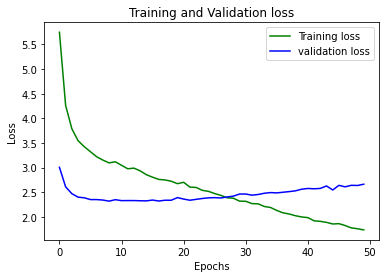

In [ ]:
import matplotlib.pyplot as plt

plt.plot(epochs, train_losses, 'g', label='Training loss')
plt.plot(epochs, test_losses, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(WORKSPACE_PATH + '/transformer_train_val.pdf')
plt.show()

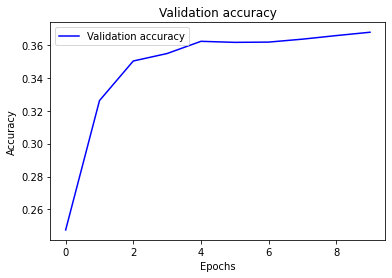

In [ ]:
plt.plot(epochs, test_phoneme_accs, 'b', label='Validation accuracy')
plt.title('Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from collections import defaultdict


samples = generate_samples(model, test_loader)
for sample in samples[0:10]:
  print(sample['target'])
  print(sample['predicted'])  
  print(sample['target_mapping'])
  print(sample['predicted_mapping'])  

  print(sample['mapping_ed'])  
  print(sample['mapping_acc'])  

['h#', 'dh', 'ax', 'bcl', 'b', 'ah', 'ng', 'g', 'ax', 'l', 'ow', 'w', 'ax', 'z', 'pcl', 'p', 'l', 'eh', 'z', 'ax', 'n', 'q', 'l', 'iy', 's', 'ih', 'tcl', 'ch', 'uw', 'w', 'ey', 'dx', 'ix', 'dcl', 'n', 'ih', 'axr', 'dh', 'ix', 'sh', 'ao', 'r', 'h#']
['h#', 'dh', 'ax', 'l', 'b', 'r', 'n', 'kcl', 'ow', 'l', 'ae', 'l', 'ax', 'n', 'ix', 'p', 'r', 'ax', 'n', 'ix', 'n', 'dcl', 'ae', 'ax', 'n', 'ix', 'n', 't', 'axr', 'ix', 'ax', 'dx', 'ix', 'n', 'd', 'dcl', 'n', 'h#', 'ax', 'n', 'en', 'r', 'ix']
[1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 7, 7, 8, 8, 8, 8]
[1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 4, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 4, 5, 6, 5, 6, 6, 8, 7, 8, 8, 7, 8, 8, 8, 8, 8, 8]
0.6046511627906976
0.5813953488372093
['h#', 'd', 'ow', 'nx', 'ae', 's', 'kcl', 'k', 'm', 'iy', 'dx', 'ix', 'kcl', 'k', 'eh', 'r', 'ih', 'ix', 'n', 'ax', 'q', 'oy', 'l', 'ih', 'r', 'ae', 'gcl', 'g', 'l', 'ay', 'kcl', 'k', 'dh', 'ae', 'tcl', 'h#']


In [ ]:
from collections import defaultdict

samples = generate_samples(model, test_loader)
len_perf_mapping = defaultdict(lambda: [])


for sample in samples:
  len_perf_mapping[len(sample['target'])].append(sample['mapping_ed'])

lengths = []
bleu_scores = []

for key, val in len_perf_mapping.items():

  lengths.append(key)
  bleu_scores.append(sum(val)/len(val))


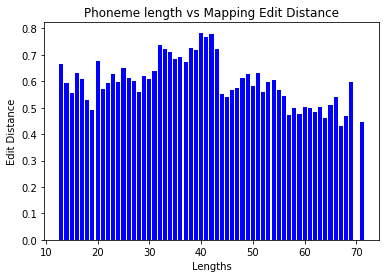

In [ ]:
plt.bar(lengths, bleu_scores, color='b')

plt.title('Phoneme length vs Mapping Edit Distance')
plt.xlabel('Lengths')
plt.ylabel('Edit Distance')
plt.savefig(WORKSPACE_PATH + '/transformer_length_analysis.pdf')
plt.show()

## Sequence Matching

In [ ]:
def match_sequences(original_phoneme_sequence, original_words, generated_phoneme_sequence):
  generated_idxs = {token : idx for idx, token in enumerate(generated)}
  original_matches = []
  for token in original:
    if token in generated_idxs: 
      original_matches.append(generated_idxs[token])
    else:
      original_matches.append(-1)
  return original_matches